### 导入相关包
    ceil起到四舍五入的作用

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from math import ceil

from datetime import datetime

from sklearn.preprocessing import StandardScaler
from dateutil.relativedelta import relativedelta

from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop

%matplotlib inline

In [3]:
test=pd.read_csv('test.csv')
train=pd.read_csv('sales_train_v2.csv')
items=pd.read_csv('items.csv')
shops=pd.read_csv('shops.csv')
item_categoriess=pd.read_csv('item_categories.csv')
submission = pd.read_csv('sample_submission.csv')

### 数据过滤
    取出在train中test有的shop_id，没有的过滤掉，取出在train中test有的item_id，没有的过滤掉

In [4]:
test_shops=test.shop_id.unique()
# 取出在train中test有的shop_id，没有的过滤掉
train=train[train.shop_id.isin(test_shops)]
test_items=test.item_id.unique()
# 取出在train中test有的item_id，没有的过滤掉
train=train[train.item_id.isin(test_items)]
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
10,03.01.2013,0,25,2574,399.0,2.0
11,05.01.2013,0,25,2574,399.0,1.0
12,07.01.2013,0,25,2574,399.0,1.0
13,08.01.2013,0,25,2574,399.0,2.0


In [5]:
MAX_BLOCK_NUM = train.date_block_num.max()
MAX_ITEM=len(test_items)
MAX_CAT=len(item_categoriess)
MAX_YEAR = 3
MAX_MONTH = 4 # 7 8 9 10
MAX_SHOP = len(test_shops)
print('MAX_BLOCK_NUM: %s \n MAX_ITEM: %s \n MAX_CAT: %s \n MAX_SHOP: %s'%(MAX_BLOCK_NUM,MAX_ITEM,MAX_CAT,MAX_SHOP))

MAX_BLOCK_NUM: 33 
 MAX_ITEM: 5100 
 MAX_CAT: 84 
 MAX_SHOP: 42


#### 数据探索

    grouped1 将每个店铺的每个月的销售产品数量都统计出来
    np.logical_and 逻辑与

In [6]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [7]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
10,03.01.2013,0,25,2574,399.0,2.0
11,05.01.2013,0,25,2574,399.0,1.0
12,07.01.2013,0,25,2574,399.0,1.0
13,08.01.2013,0,25,2574,399.0,2.0


In [8]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [9]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [10]:
item_categoriess.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [11]:
submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [12]:
grouped = pd.DataFrame(train.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index())
grouped.head(5)

,shop_id,date_block_num,item_cnt_day
0,2,0,248.0
1,2,1,135.0
2,2,2,237.0
3,2,3,168.0
4,2,4,159.0


#### 查看每個商店的每個月的商品銷售量

    hue（str）：dataframe的列名，按照列名中的值分类形成分类，即左上角、右上角的label
    
    sharex=True, sharey=True 共享x和y轴的坐标

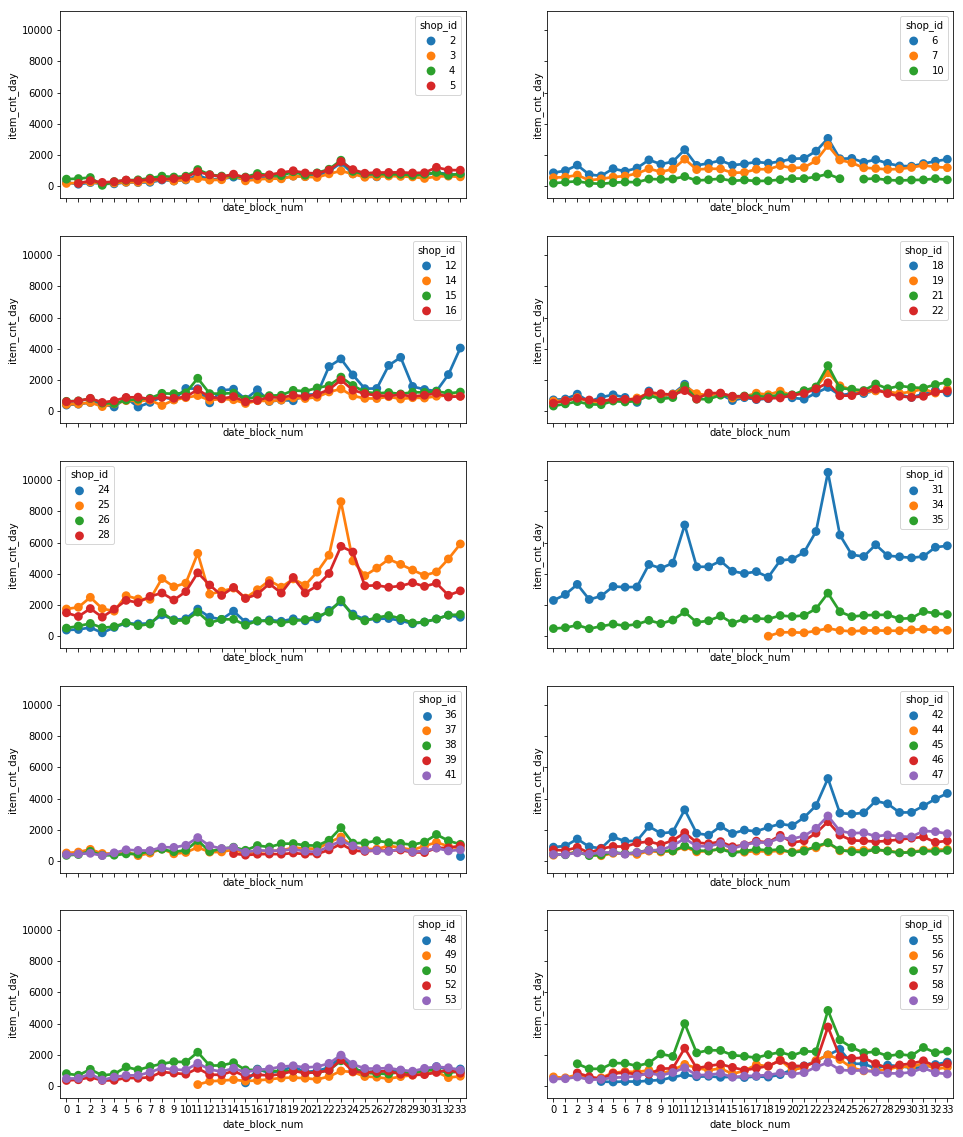

In [13]:
fig,axes=plt.subplots(5,2,sharex=True, sharey=True,figsize=(16,20))
count=0
num_graph=10
id_per_graph=ceil(grouped.shop_id.max()/num_graph)
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num',y='item_cnt_day',hue='shop_id',data=grouped[np.logical_and(count*id_per_graph <= grouped['shop_id'], grouped['shop_id'] < (count+1)*id_per_graph)],ax=axes[i][j])
        count+=1

In [14]:
# 根据索引 item_id 对应顺序，将items中的数据加入到train中
train=train.set_index('item_id').join(items.set_index('item_id')).drop(columns='item_name').reset_index()
# train.head()

In [15]:
# 将 train.date 中的数据格式化成时间格式，然后只保留月份
train['month'] = train.date.apply(lambda x: datetime.strptime(x, '%d.%m.%Y').strftime('%m'))
train['year'] = train.date.apply(lambda x: datetime.strptime(x, '%d.%m.%Y').strftime('%Y'))

#### 此时使用train.info()我们可以看到 month year是object类型

In [16]:
 train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1224439 entries, 0 to 1224438
Data columns (total 9 columns):
item_id             1224439 non-null int64
date                1224439 non-null object
date_block_num      1224439 non-null int64
shop_id             1224439 non-null int64
item_price          1224439 non-null float64
item_cnt_day        1224439 non-null float64
item_category_id    1224439 non-null int64
month               1224439 non-null object
year                1224439 non-null object
dtypes: float64(2), int64(4), object(3)
memory usage: 84.1+ MB


In [17]:
train.head(5)

,item_id,date,date_block_num,shop_id,item_price,item_cnt_day,item_category_id,month,year
0,30,28.02.2013,1,50,399.0,1.0,40,02,2013
1,30,26.02.2013,1,50,399.0,1.0,40,02,2013
2,30,12.02.2013,1,50,399.0,1.0,40,02,2013
3,30,14.02.2013,1,50,399.0,2.0,40,02,2013
4,30,15.02.2013,1,50,399.0,3.0,40,02,2013


In [18]:
train['year'].unique()

array(['2013', '2014', '2015'], dtype=object)

In [19]:
train['month'].unique()

array(['02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12',
       '01'], dtype=object)

In [20]:
train[(train['item_category_id']==9) & (train['month']== '05')& (train['year']== '2013')]['item_cnt_day'].mean()

2.7142857142857144

In [21]:
train[(train['item_category_id']==9) & (train['month']== '05')& (train['year']== '2014')]['item_cnt_day'].mean()

12.5

In [22]:
train[(train['item_category_id']==9) & (train['month']== '05')& (train['year']== '2015')]['item_cnt_day'].mean()

22.27777777777778

#### 查看每个月每个项目类别(item_category_id)的销售量(item_cnt_day) - 每年的相同月之间求均
    
    图中的竖线为误差线，通过capsize可以定义误差棒最顶上和最下面的横线长度，误差线表示关于该估计的不确定性的一些指示。可能是因为这个月销售量波动很大的原因造成的

5月时9号商品最大销售额

In [23]:
train[(train['item_category_id']==9) & (train['month']== '05')]['item_cnt_day'].max()

539.0

5月时9号商品最小销售额

In [24]:
train[(train['item_category_id']==9) & (train['month']== '05')]['item_cnt_day'].min()

1.0

9


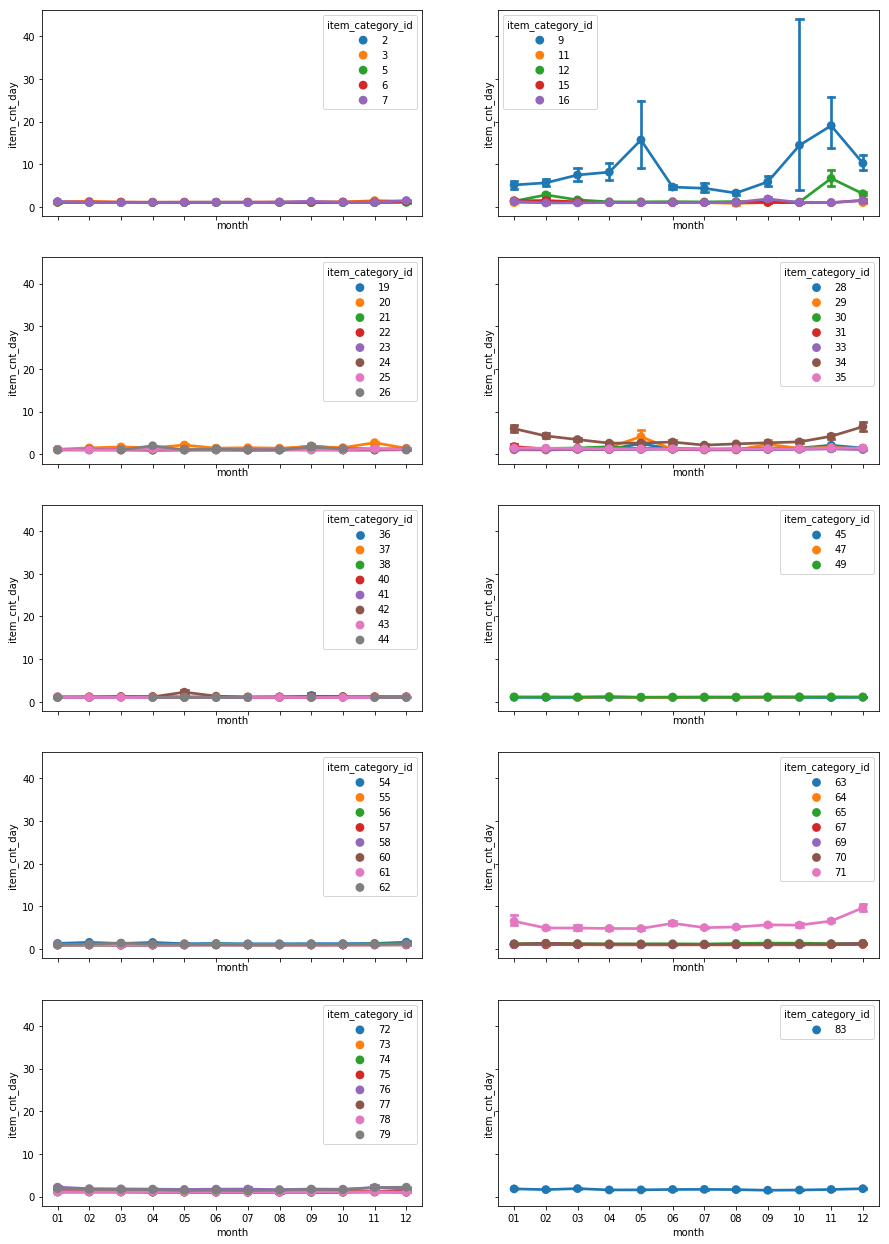

In [25]:
fig,axes=plt.subplots(5,2,sharex=True,sharey=True,figsize=(15,22))
num_graph=10
count=0
id_per_graph=ceil(train.item_category_id.max()/num_graph)
print(id_per_graph)
for i in range(5):
    for j in range(2):
        sns.pointplot(x='month',y='item_cnt_day',hue='item_category_id',capsize=.2,data=train[np.logical_and(count*id_per_graph <= train['item_category_id'],train['item_category_id'] < (count+1)*id_per_graph)],ax=axes[i][j])
        count+=1

In [26]:
train['date_block_num'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,  0],
      dtype=int64)

In [27]:
train[(train['item_category_id']==9) & (train['date_block_num']== 33)]['item_cnt_day'].max()

2169.0

In [28]:
train[(train['item_category_id']==9) & (train['date_block_num']== 33)]['item_cnt_day'].min()

1.0

#### 查看每一年每一个月的销售产品数量(item_cnt_day)和item_category_id之间的关系

In [ ]:
fig,axes=plt.subplots(5,2,sharex=True,sharey=True,figsize=(15,22))
num_graph=10
count=0
id_per_graph=ceil(train.item_category_id.max()/num_graph)
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num',y='item_cnt_day',hue='item_category_id',capsize=.2,data=train[np.logical_and(count*id_per_graph <= train['item_category_id'],train['item_category_id'] < (count+1)*id_per_graph)],ax=axes[i][j])
        count+=1

In [ ]:
train.head()

In [ ]:
train = train.drop('date', axis=1)
train = train.drop('item_category_id', axis=1)
train = train.groupby(['shop_id', 'item_id', 'date_block_num', 'month', 'year']).sum()
train = train.sort_index()
train.head()

#### 此时我们使用info()查看数据，但是却只显示出了两行，好像其他数据是临时拿来组合的（通过groupby)。
    
    此时我们无法通过制定显示出来的列名进行查询，比如我们如果使用train['shop_id']就会报错，因为这个shop_id是我们拼接进去的没有这个列，如果想进行定位需要靠loc，如train.loc[2]即定位第一列标签为2的值，也就是我们的shop_id=2的所有内容,同时也可以指定多个标签，因为我们上面将shop_id', 'item_id', 'date_block_num', 'month', 'year'都设置成了标签，如果要结合多个标签则，train.loc[(2,30,2)] 表示shop_id=2，item_id=30，date_block_num	=2

In [ ]:
train.info()

#### 数据归一化

In [ ]:
price_ss=StandardScaler()
cnt_ss=StandardScaler()

In [ ]:
# .reshape(-1, 1)让数据变成一列多行
train.item_price=price_ss.fit_transform(train.item_price.values.reshape(-1,1))
train.item_cnt_day=cnt_ss.fit_transform(train.item_cnt_day.values.reshape(-1,1))

#### 使用groupby切分之后吗，其实是不影响我们原先的数据的，你可以我们可以再通过输出train发现，train数据还是原先的数据，如果想改变可以使用覆盖

In [ ]:
train.reset_index().groupby(['shop_id','item_id','date_block_num']).mean()

#### 我们改变groupby的顺序，使得item_id放前面，表示每个商品在每个店铺下的数据信息

In [ ]:
price = train.reset_index().set_index(['item_id', 'shop_id', 'date_block_num'])
price = price.sort_index()

In [ ]:
price.head()

In [ ]:
price.loc[(30, 2)].index

In [ ]:
price.info()

#### 函数介绍：
    
    convert：日期转换，在数据中，我们的 date_block_num 是从0开始的，表示0为1月，所以我们上面采用 convert 函数进行日期转换
    
    closest_date_block：返回离当前月份最近一个月份的商品当前价格作为我们的该月商品的当前价格的月份index
    
    closest_price：返回离当前月份最近一个月份的商品当前价格作为我们的该月商品的当前价格

In [ ]:
def convert(date_block):
    date = datetime(2013, 1, 1)
    date += relativedelta(months = date_block)
    return (date.month, date.year)

def closest_date_block(current_mouth, item_id, shop_id):
    """ 这里注意了，因为有的产品在有些店铺中，有些月份是没有被成功销售出去的，所以那个月份没有该产品的数据，这里我们要造出那些数据。
        但是其中的该月商品的当前价格是会发生变化的，我们解决的方法是，采用离当前月份最近一个月份的商品当前价格作为我们的该月商品的当前价格的月份index"""
    if (item_id, shop_id) in price.index:
        """通过将(item_id, shop_id)组合设为标签，进行数据定位，找到对应的index值，因为这里已经将(item_id, shop_id)的内容取出了，所以只剩下
           date_block_num作为我们的index值，这里就可以拿到符合的所有 date_block_num，作为列表返回
        """
        search_lst = np.array(price.loc[(item_id, shop_id)].index)   
#         print(search_lst)
#         print(search_lst[np.abs(current_mouth - search_lst).argmin()])
        """ 通过 current_mouth 和搜索出来的月份(date_block_num)进行匹配，找到最近的月份进行返回 """
        return search_lst[np.abs(current_mouth - search_lst).argmin()]
    return -1
                
def closest_price(current_mouth, item_id, shop_id):
    current_mouth = closest_date_block(current_mouth, item_id, shop_id)
    """ 如果存在 item_id 和 shop_id 为标签的内容，就执行下面代码"""
    if current_mouth != -1:
        """可以通过在loc中用()定位到多个标签组合后的内容,返回商品的当前价格"""
        return price.loc[( item_id, shop_id, current_mouth )]['item_price']
    return np.nan

def closest_price_lambda(x):
    return closest_price(34, x.item_id, x.shop_id)

In [ ]:
np.array(price.loc[(30, 2)].index) 

In [ ]:
np.abs(6 - np.array(price.loc[(30, 2)].index) ).argmin()

In [ ]:
closest_price(6, 30, 2)

In [ ]:
train.head()

#### 我们将学习2013年和2014年7月，8月，9月，10月的顺序。比如说：2013年1月或任何时间附近的销售数据不太可能对2015年11月的销售产生任何影响

    BLOCKS定义6，18，30 表示，我们从 date_block_num=6 (6+1月份) 开始计时(因为date_block_num从0开始，0表示一月份，我们会将传进来的值进行转换)通过 maxlen变量循环 分别获取 2013 的 7 8 9 10 月份和 2014 的 7 8 9 10 月份，2015 的 7 8 9 10 月份的销售数据
    
    sentences中存储我们 2013 的 7 8 9 10 月份，2014 的 7 8 9 10 月份，2015 的 7 8 9 10 月份的销售数据分别用于0: train(训练集), 1: val(交叉验证集), 2:test(测试集)

In [ ]:
maxlen = 4 # 4 months
step = 1
# 0: train(训练集), 1: val(交叉验证集), 2:test(测试集)
sentences = [[],[],[]]
next_chars = [[], []]
# 月份
BLOCKS = [6, 18, 30]

"""得到每个测试集中的shop_id"""
for s in test_shops:
    """通过shop_id定位到对应该商店下的所有信息，然后取出item_id这一列的数据，进行去重，最终得到这个店铺的所有item_id值"""
    shop_items = list(train.loc[s].index.get_level_values(0).unique())
    """循环shop_items得到每一个item_id"""
    for it in shop_items:  
        """通过item_id的值，我们可以去查询到该产品在对应的月份中商品的当前价格"""
        for i_index, i in enumerate(BLOCKS):
            sentence = []
            """ 分别会存储 6 月份 18 月份 30 月份的商品当前价格"""
            closest_pc = closest_price(i, it, s) 
            print("closest_pc: ",closest_pc)
            """ 我们将学习2013年和2014年7月，8月，9月，10月的顺序。
            比如说：2013年1月或任何时间附近的销售数据不太可能对2015年11月的销售产生任何影响。"""
            for j in range(maxlen+1):
                if j < maxlen:
                    month, year = convert(i + j)
                    """如果 店铺id + item_id + 月份存在，则记录下以下信息(row中的信息)"""
                    if (s, it, i+j) in train.index:
#                         print("s: %s, it: %s ,i: %s ,j: %s ,i+j: %s : "%(s,it,i,j,i+j))
                        """(5, 30, 9) 为例输出 {'item_cnt_day': [-0.15018864969036175], 'item_price': [-0.2757597800953987]} """
                        r = train.loc[(s, it, i + j)].to_dict(orient='list')
                        closest_pc = r['item_price'][0]
                        item_cnt_day = r['item_cnt_day'][0]
                        row = {'shop_id': s, 'date_block_num': i+j, 'item_cnt_day': item_cnt_day, 
                               'month': month, 'item_id': it, 'item_price': closest_pc, 'year': year}
                        
#                     """如果 店铺id + item_id + 月份不存在，则将item_cnt_day(当日销售数量)记为0，
#                     商品当前价格延续为之前最近月份的商品的当前价格然后进行数据的构造"""
                    else:
                        month, year = convert(i+j)                    
                        row = {'shop_id': s, 'date_block_num': i+j, 'item_cnt_day': 0, 
                               'month': month, 'item_id': it, 'item_price': closest_pc, 'year': year}
                    print('row: ',row)
                    sentence.append(row)
                    
                    """ sentence数据: 例如
                    [
                    row:  {'shop_id': 5, 'date_block_num': 30, 'item_cnt_day': 0, 'month': 7, 'item_id': 64, 'item_price': -0.27861184470038636, 'year': 2015},
                    row:  {'shop_id': 5, 'date_block_num': 31, 'item_cnt_day': 0, 'month': 8, 'item_id': 64, 'item_price': -0.27861184470038636, 'year': 2015},
                    row:  {'shop_id': 5, 'date_block_num': 32, 'item_cnt_day': 0, 'month': 9, 'item_id': 64, 'item_price': -0.27861184470038636, 'year': 2015},
                    row:  {'shop_id': 5, 'date_block_num': 33, 'item_cnt_day': 0, 'month': 10, 'item_id': 64, 'item_price': -0.27861184470038636, 'year': 2015}
                    ]
                    """
                # i_index < 2 表示我们月份还在2013，2014年，某商店，某产品，10月份的销售数据，因为在上面if条件结束时月份刚好为10月份
                elif i_index < 2:   # not in test set
                    next_chars[i_index].append(row)
#                     print('row2: ',row)


            # 首先传进来的是6月份，我们在6月份里面循环，然后记录row信息，保存在sentences[0]中(包含了存在和数据和构造的数据)，以此类推
            # 分别存储的是 2013年和2014年的sentence数据 6月份对应的i_index为0,18月份对应的i_index为1，30月份对应的i_index为2
            sentences[i_index].append(sentence)

#### 找到对应的标签值(shop_id),因为之前已经我们已经基于(shop_id)排序过了,如果只想看item_id=30的数据可以在后面指明想要看的列数
    如：train.loc[2,30].head()

In [ ]:
# train.head()

In [ ]:
# train.loc[5].index.get_level_values(0).unique()

#### 分别得到训练数据、交叉验证数据、测试数据

In [ ]:
train_x=np.array(sentences[0])
val_x=np.array(sentences[0])
test_x=np.array(sentences[0])

train_y=np.array([x['item_cnt_day'] for x in next_chars[0]])
val_y=np.array([x['item_cnt_day'] for x in next_chars[1]])

In [ ]:
length = MAX_SHOP + MAX_ITEM + MAX_MONTH + 1 + 1 + 1
length

In [ ]:
len(test_items)

In [ ]:
test_shops

### 构造Onehot向量

#### LabelEncoder可以将标签分配一个0—n_classes-1之间的编码 

In [ ]:
from sklearn import preprocessing
shop_le=preprocessing.LabelEncoder()
shop_le.fit(test_shops)
shop_dm=dict(zip(test_shops,shop_le.transform(test_shops)))

item_le=preprocessing.LabelEncoder()
item_le.fit(test_items)
item_dm=dict(zip(test_items,item_le.transform(test_items)))

month_le = preprocessing.LabelEncoder()
month_le.fit(range(7,11))
month_dm = dict(zip(range(7,11), month_le.transform(range(7,11))))
month_dm

In [ ]:
train_x[1][0]

In [ ]:
shop_dm[5]

In [ ]:
item_dm[31]

In [ ]:
def vectorize(inp):
    print('Vectorization...')
    # (len(inp) 为最外层数组个数，maxlen为，每个数组的行数，length为每个数组的列数，三个参数一共三维
    x = np.zeros((len(inp), maxlen, length), dtype=np.float32)
    for i, sentence in enumerate(inp):
        for t, char in enumerate(sentence):   
            # 将对应的label置为响应的数，比如说我们读取出来第一条char的shop_id=5,他对应的shop_dm[5]=3，我们将第三个位置置1
            x[i][t][ shop_dm[char['shop_id']]] = 1        
            x[i][t][ MAX_SHOP + item_dm[char['item_id']]] = 1
            x[i][t][ MAX_SHOP + MAX_ITEM + month_dm[char['month']] ] = 1
            x[i][t][ MAX_SHOP + MAX_ITEM + MAX_MONTH + 1 ] = char['item_price']
            x[i][t][ MAX_SHOP + MAX_ITEM + MAX_MONTH + 1 + 1] = char['item_cnt_day']    
    return x

In [ ]:
x_train[1][1]

In [ ]:
x_train = vectorize(train_x)
x_val = vectorize(val_x)
x_test = vectorize(test_x)